In [1]:
import pickle
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.spatial.distance import euclidean
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.spatial.distance import cdist
import umap.umap_ as umap
import matplotlib.colors as mcolors

In [2]:
sp_labels = {0: "Diamond, 3000K",
             1: "Graphite, 3000K",
             2: "0.5 gcc, 1000K",
             3: "1.0 gcc, 2000K",
             4: "2.0 gcc, 6000K",
             5: "3.6 gcc, 6000K",
             6: "3.0 gcc, 8000K",
             7: "Diamond, 300K",
             8: "Graphite, 300K",
             9: "Graphite, 1500K",
             10: "2.0 gcc, 7000K",
             11: "2.5 gcc, 6000K"}

Ground Truth

In [3]:
with open("2b_avg_pd_equilibrium", 'rb') as pickle_file:
    avg_pd_2b = pickle.load(pickle_file)

with open("3b_avg_pd_equilibrium", 'rb') as pickle_file:
    avg_pd_3b = pickle.load(pickle_file)

with open("4b_avg_pd_equilibrium", 'rb') as pickle_file:
    avg_pd_4b = pickle.load(pickle_file)

# Combine the arrays along the second axis (axis=1)
combined_array = np.concatenate((avg_pd_2b, avg_pd_3b, avg_pd_4b), axis=1)

# Verify the shape of the combined array
print(combined_array.shape)  # Output will be (12, 180, 1)

# Reshape the array to (12, 60) before creating the DataFrame
reshaped_data = np.array(combined_array).reshape(12, 180)

# Create a DataFrame
avg_df = pd.DataFrame(reshaped_data) # Ground Truth

(12, 180, 1)


Equilibrium P(d) UMap Representation

(12, 13, 180)
(156, 180)
(156,)
Accuracy: 0.9551282051282052


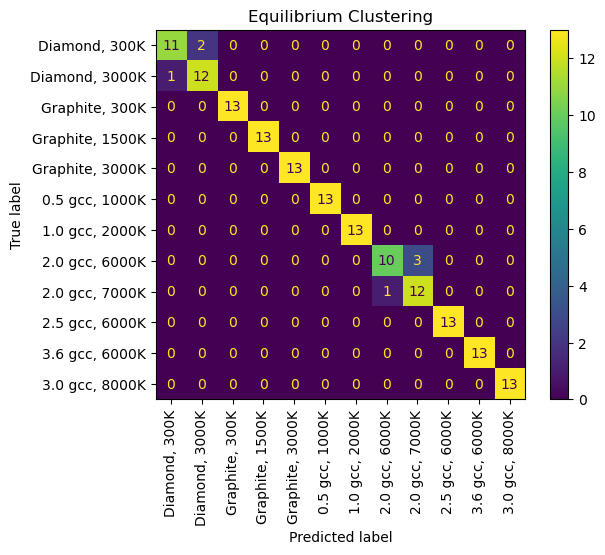

/Users/blaubach/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/var/folders/qt/6k9t6mfn12l30tsrj8hnl6wh0000gs/T/ipykernel_25088/4282985278.py:86: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x, y, z, s=50, c=color_map[color], marker=shape_map[shape], alpha=0.5, label=f'Cluster {color} Shape {shape}')


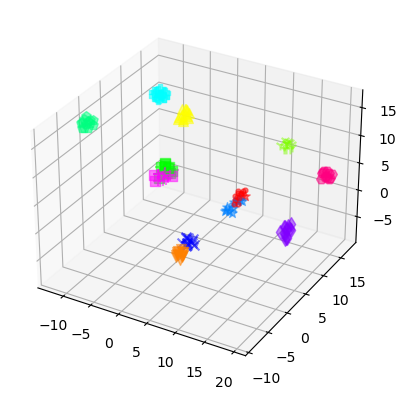

<Figure size 800x600 with 0 Axes>

In [36]:
a
closest_clusters = []
for i, row in all_equilibrium_df.iterrows():
    # Compute distances to all clusters in the original data
    distances_to_clusters = cdist([row], avg_df) # Computes the 2-norm between point and ground truth data
    # Find the index of the closest cluster in the original data
    closest_cluster_index = np.argmin(distances_to_clusters)
    closest_clusters.append(closest_cluster_index)
# Compute accuracy
accuracy = accuracy_score(labels, closest_clusters)
print("Accuracy:", accuracy)

cm = confusion_matrix(labels, closest_clusters)

# Define the new order of indices for visualization
new_order = [7, 0, 8, 9, 1, 2, 3, 4, 10, 11, 5, 6]
 
# Reorder rows and columns of the confusion matrix
reordered_cm = cm[new_order][:, new_order]
 
# Sort the sp_labels dictionary based on the new_order
sorted_sp_labels = {k: sp_labels[k] for k in sorted(sp_labels, key=lambda x: new_order.index(x))}
 
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=reordered_cm,
                               display_labels=[sorted_sp_labels[i] for i in sorted_sp_labels.keys()])
disp.plot(xticks_rotation=90)
plt.title("Equilibrium Clustering")
plt.show()

# Create a UMAP model with 2 components (dimensions)
umap_model = umap.UMAP(random_state=7, n_components=3, n_neighbors=12, min_dist=0.99, metric='euclidean')

# Combine the all_equilibrium and avg dataframes
# frames = [all_equilibrium_df, avg_df]
# all_df = pd.concat(frames)
fig = plt.figure()
ax = plt.axes(projection='3d')

# Fit the UMAP model to your data and transform it to 2 dimensions
embedding = umap_model.fit_transform(all_equilibrium_df)
all_embedding = embedding

# Plot the embedded data with colors and shapes based on labels
plt.figure(figsize=(8, 6))  # Adjust figure size if needed

# Define the number of unique labels
num_labels = 12
size = 24

# Create a colormap using the 'hsv' colormap
color_map = [mcolors.hsv_to_rgb([i / num_labels, 1, 1]) for i in range(num_labels)]

shape_map = [".","v","^","1","s","p","P","*","x","d","+","H"]    # Add more shapes if needed

# Plot points based on closest clusters
for i in range(len(closest_clusters)-1):
    color = closest_clusters[i]  # Color based on closest cluster
    shape = labels[i]         # Shape based on arr_labels
    x, y, z = all_embedding[i]      # Coordinates of the point
    
    ax.scatter(x, y, z, s=50, c=color_map[color], marker=shape_map[shape], alpha=0.5, label=f'Cluster {color} Shape {shape}')

# plt.scatter(avg_embedding[:, 0], avg_embedding[:, 1], s=12, c="black", label="Avg. P(d)")
# plt.scatter(all_embedding[:, 0], all_embedding[:, 1], s=12, label="Avg. P(d)")
# plt.xlabel('Dimension 1', fontsize=size)
# plt.ylabel('Dimension 2', fontsize=size)
# plt.xticks(fontsize=size-6)
# plt.yticks(fontsize=size-6)
# plt.title('UMAP Representation of Data', fontsize=size+2)
# plt.show()


/var/folders/qt/6k9t6mfn12l30tsrj8hnl6wh0000gs/T/ipykernel_25088/3935946923.py:32: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, s=50, c=color_map[color], marker=shape_map[shape], alpha=0.5, label=f'Cluster {color} Shape {shape}')


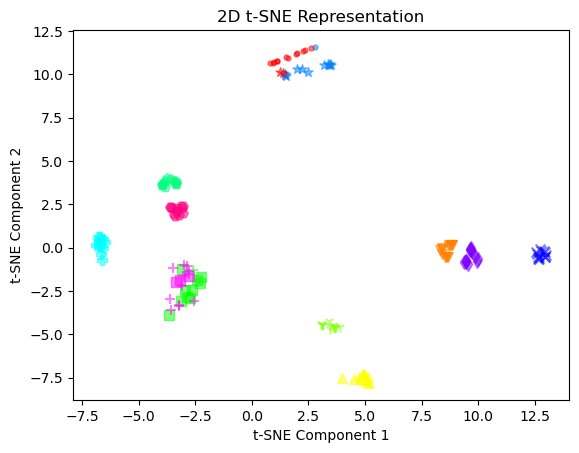

In [39]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Assuming all_equilibrium_df is your DataFrame containing feature vectors

# Step 1: Prepare Data
# Extract feature vectors from your DataFrame
X = all_equilibrium_df.values  # Assuming your features are in columns

# Step 2: Normalize Data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Step 3: Apply t-SNE
# Create a t-SNE model
tsne = TSNE(n_components=2, random_state=42)

# Fit and transform the data to the 2D space
X_2d = tsne.fit_transform(X_normalized)

# fig = plt.figure()
# ax = plt.axes(projection='3d')


# Plot points based on closest clusters
for i in range(len(closest_clusters)-1):
    color = closest_clusters[i]  # Color based on closest cluster
    shape = labels[i]         # Shape based on arr_labels
    x, y = X_2d[i]      # Coordinates of the point
    
    plt.scatter(x, y, s=50, c=color_map[color], marker=shape_map[shape], alpha=0.5, label=f'Cluster {color} Shape {shape}')
# Visualize the 2D t-SNE representation
#plt.scatter(X_2d[:, 0], X_2d[:, 1], marker='.', color='b')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('2D t-SNE Representation')
plt.show()


(300, 180)
Accuracy: 0.9033333333333333


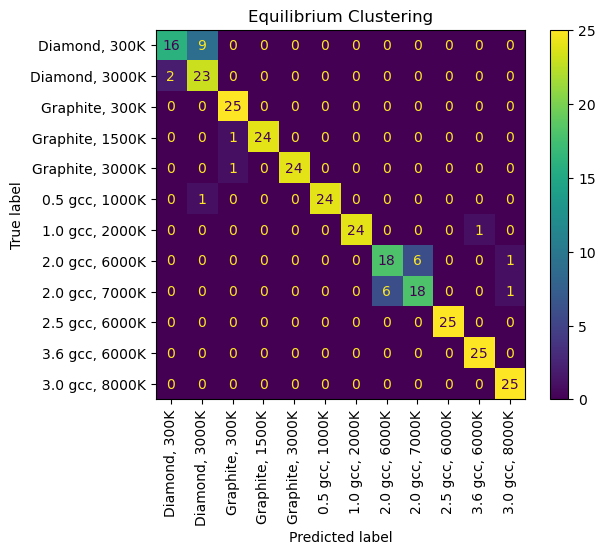

/var/folders/qt/6k9t6mfn12l30tsrj8hnl6wh0000gs/T/ipykernel_25088/2109730998.py:79: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, s=50, c=color_map[color], marker=shape_map[shape], alpha=0.5, label=f'Cluster {color} Shape {shape}')


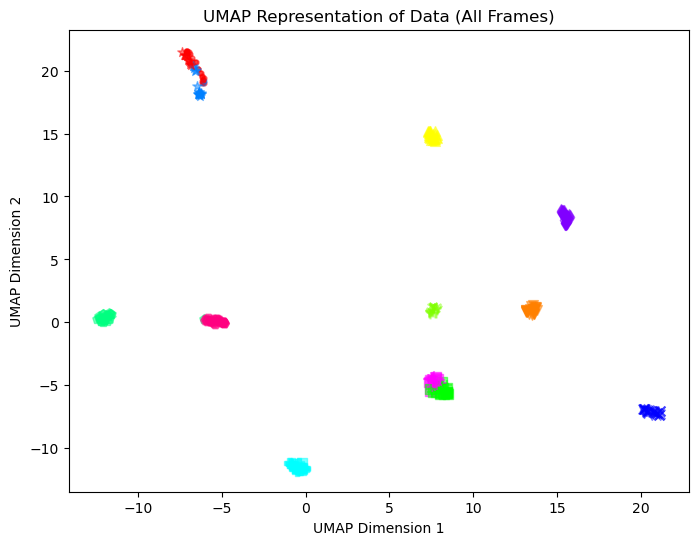

In [5]:
with open("2b_all_pd", 'rb') as pickle_file:
    pd_2b = pickle.load(pickle_file)

with open("3b_all_pd", 'rb') as pickle_file:
    pd_3b = pickle.load(pickle_file)

with open("4b_all_pd", 'rb') as pickle_file:
    pd_4b = pickle.load(pickle_file)

# Combine the arrays along the second axis (axis=1)
all_array = np.concatenate((pd_2b, pd_3b, pd_4b), axis=2)
all_array = all_array.reshape(-1,all_array.shape[2])
print(np.shape(all_array))

# Create labels array
# Define the maximum number of repetitions for each number
max_repetitions = 25
# Define the range of numbers from 0 to 11
numbers_range = np.arange(12)
# Create the array
labels = np.repeat(numbers_range, max_repetitions)
all_df = pd.DataFrame(all_array)
all_df['labels'] = labels
all_df.fillna(0, inplace=True)
all_df.drop(columns=['labels'], inplace=True)

closest_clusters = []
for i, row in all_df.iterrows():
    # Compute distances to all clusters in the original data
    distances_to_clusters = cdist([row], avg_df) # Computes the 2-norm between point and ground truth data
    # Find the index of the closest cluster in the original data
    closest_cluster_index = np.argmin(distances_to_clusters)
    closest_clusters.append(closest_cluster_index)
# Compute accuracy
accuracy = accuracy_score(labels, closest_clusters)
print("Accuracy:", accuracy)

cm = confusion_matrix(labels, closest_clusters)

# Define the new order of indices for visualization
new_order = [7, 0, 8, 9, 1, 2, 3, 4, 10, 11, 5, 6]

# Reorder rows and columns of the confusion matrix
reordered_cm = cm[new_order][:, new_order]
 
# Sort the sp_labels dictionary based on the new_order
sorted_sp_labels = {k: sp_labels[k] for k in sorted(sp_labels, key=lambda x: new_order.index(x))}
 
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=reordered_cm,
                               display_labels=[sorted_sp_labels[i] for i in sorted_sp_labels.keys()])
disp.plot(xticks_rotation=90)
plt.title("Equilibrium Clustering")
plt.show()

# Create a UMAP model with 2 components (dimensions)
umap_model = umap.UMAP(n_components=2)

# Fit the UMAP model to your data and transform it to 2 dimensions
embedding = umap_model.fit_transform(all_df)

# Plot the embedded data with colors and shapes based on labels
plt.figure(figsize=(8, 6))  # Adjust figure size if needed

# Define the number of unique labels
num_labels = 12

# Create a colormap using the 'hsv' colormap
color_map = [mcolors.hsv_to_rgb([i / num_labels, 1, 1]) for i in range(num_labels)]

shape_map = [".","v","^","1","s","p","P","*","x","d","+","H"]    # Add more shapes if needed

# Plot points based on closest clusters
for i in range(len(closest_clusters)):
    color = closest_clusters[i]  # Color based on closest cluster
    shape = labels[i]         # Shape based on arr_labels
    x, y = embedding[i]      # Coordinates of the point
    
    plt.scatter(x, y, s=50, c=color_map[color], marker=shape_map[shape], alpha=0.5, label=f'Cluster {color} Shape {shape}')
    #plt.scatter(x, y, s=50, c=color_map[color], marker=shape_map[shape], alpha=0.5, label=f'Cluster {color} Shape')
    #plt.scatter(x, y, s=50, c=color_map[color], marker=shape_map[shape], alpha=0.5)

plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP Representation of Data (All Frames)')
plt.show()


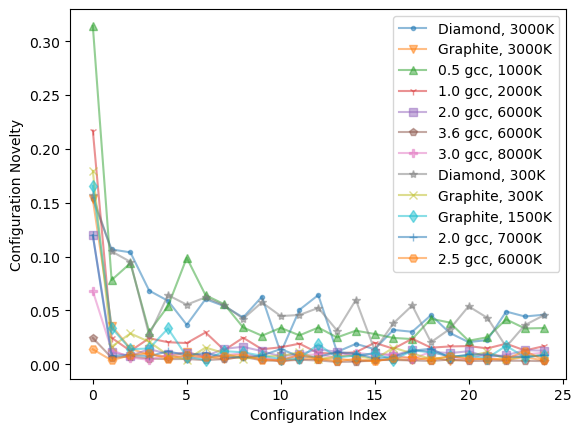

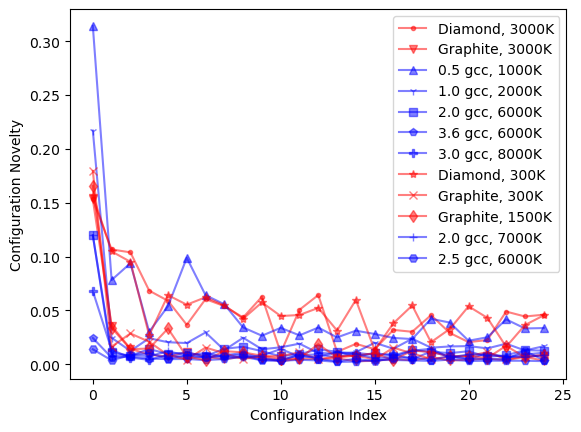

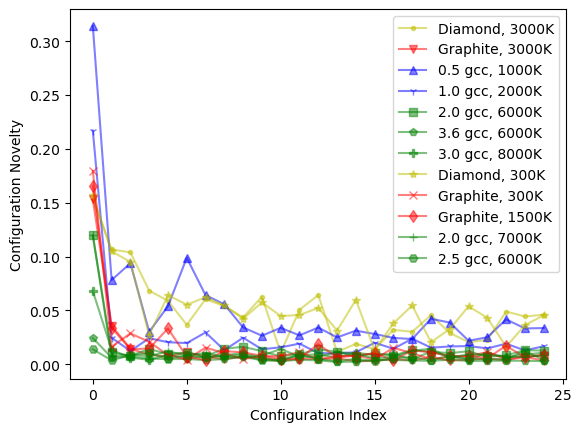

In [6]:
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

solids = [0, 1, 7, 8, 9]
graphites = [1, 8, 9]
ld_liquids = [2, 3]
hd_liquids = [4, 5, 6, 10, 11]
diamonds = [0, 7]
liquids = [2, 3, 4, 5, 6, 10, 11]

# Add labels to all_df
all_df['labels'] = labels

# Define an empty list to store distances for each label
all_distances = []

# Iterate through labels 0 to 11
for label in range(12):
    # Filter rows with the current label
    all_df_label = all_df[all_df['labels'] == label]

    # Initialize an empty list to store distances for the current label
    distances = []

    # Iterate through rows with the current label
    for i, row in all_df_label.iterrows():
        # Ignore the last element (label) in the row
        row_data = row.iloc[:-1].values.reshape(1, -1)

        # Compute distances to all clusters in the original data
        distances_to_clusters = cdist(row_data, avg_df)  # Exclude the last column (label) in avg_df

        # Find the minimum distance
        min_distance = distances_to_clusters.min()

        # Append the minimum distance to the list
        distances.append(min_distance)

    # Append the list of distances for the current label to the list of all distances
    all_distances.append(distances)

# Plot the distances for each label
for i, distances in enumerate(all_distances):
    x_values = range(len(distances))
    plt.plot(x_values, distances, label=sp_labels.get(i, f'Curve {i}'), marker=shape_map[i], linestyle='-', alpha=0.5)

# Add labels and title
plt.xlabel('Configuration Index')
plt.ylabel('Configuration Novelty')
plt.legend()
plt.show()

# Plot the distances for each label
for i, distances in enumerate(all_distances):
    x_values = range(len(distances))
    if i in solids:
        plt.plot(x_values, distances, color='r', label=sp_labels.get(i, f'Curve {i}'), marker=shape_map[i], linestyle='-', alpha=0.5)
    elif i in liquids:
        plt.plot(x_values, distances, color='b', label=sp_labels.get(i, f'Curve {i}'), marker=shape_map[i], linestyle='-', alpha=0.5)

# Add labels and title
plt.xlabel('Configuration Index')
plt.ylabel('Configuration Novelty')
plt.legend()
plt.show()

# Plot the distances for each label
for i, distances in enumerate(all_distances):
    x_values = range(len(distances))
    if i in graphites:
        plt.plot(x_values, distances, color='r', label=sp_labels.get(i, f'Curve {i}'), marker=shape_map[i], linestyle='-', alpha=0.5)
    elif i in ld_liquids:
        plt.plot(x_values, distances, color='b', label=sp_labels.get(i, f'Curve {i}'), marker=shape_map[i], linestyle='-', alpha=0.5)
    elif i in hd_liquids:
        plt.plot(x_values, distances, color='g', label=sp_labels.get(i, f'Curve {i}'), marker=shape_map[i], linestyle='-', alpha=0.5)
    elif i in diamonds:  # Check if the current label is in the diamonds list
        plt.plot(x_values, distances, color='y', label=sp_labels.get(i, f'Curve {i}'), marker=shape_map[i], linestyle='-', alpha=0.5)

# Add labels and title
plt.xlabel('Configuration Index')
plt.ylabel('Configuration Novelty')
plt.legend()
plt.show()


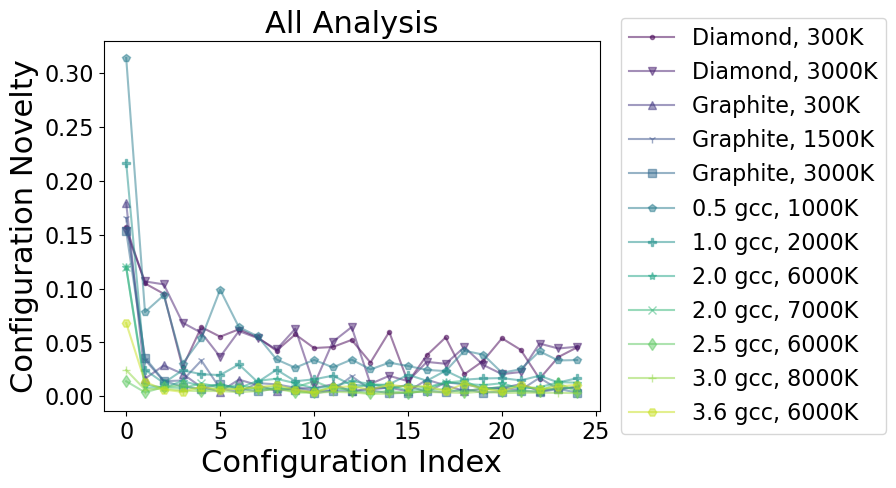

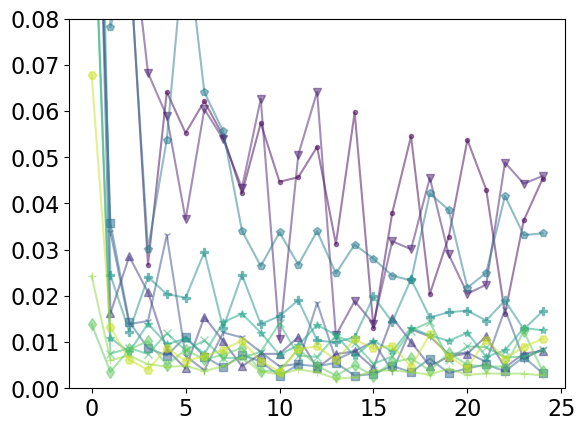

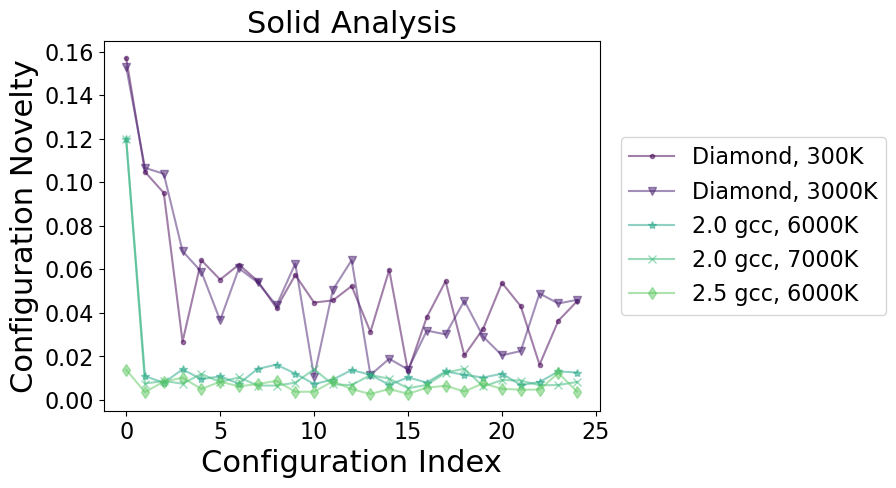

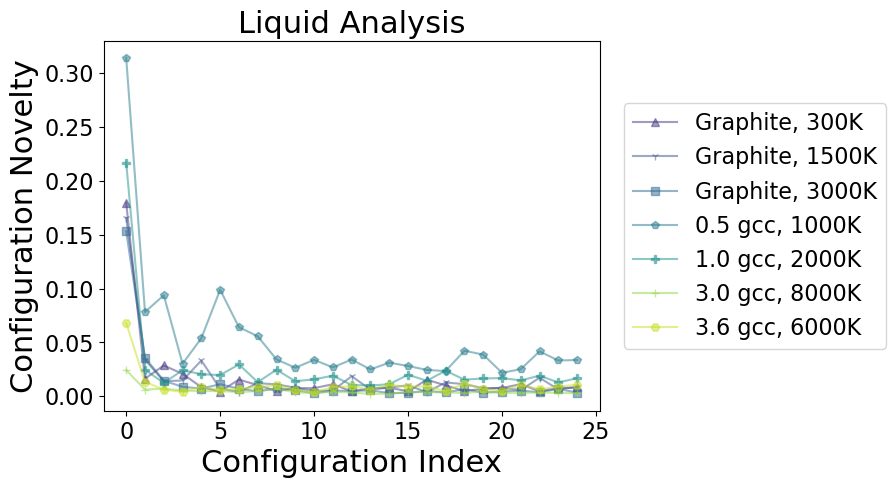

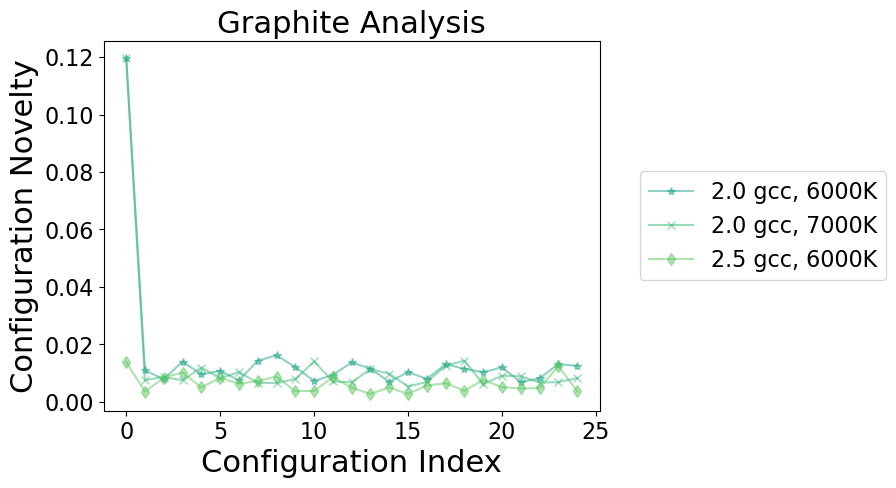

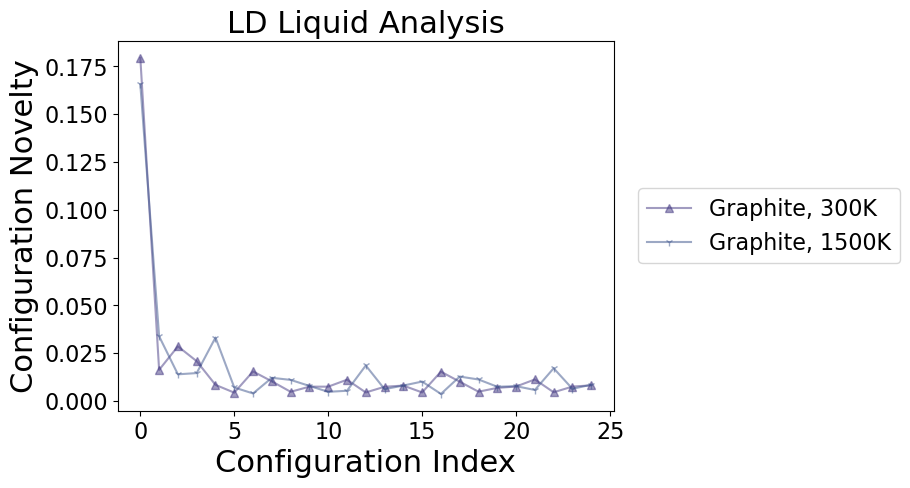

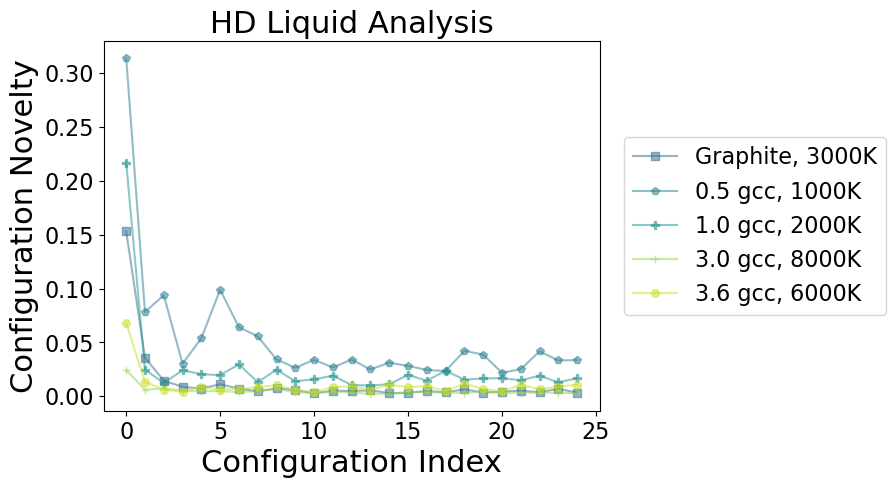

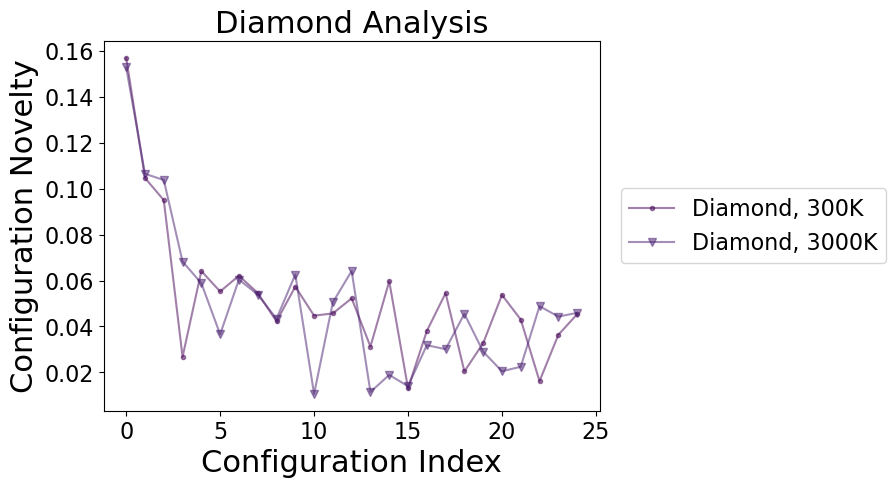

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

solids = [0, 1, 7, 8, 9]
graphites = [7, 8, 9]
ld_liquids = [2, 3]
hd_liquids = [4, 5, 6, 10, 11]
diamonds = [0, 1]
liquids = [2, 3, 4, 5, 6, 10, 11]

# Make a copy of the original array
all_distances_copy = np.copy(all_distances)

# Swap rows 1 and 7 in the copy
all_distances_copy[[1, 7]] = all_distances_copy[[7, 1]]
all_distances_copy[[5, 10]] = all_distances_copy[[10, 5]]
all_distances_copy[[6, 11]] = all_distances_copy[[11, 6]]
all_distances_copy[[10, 11]] = all_distances_copy[[10, 11]]
all_distances_copy[[7, 8]] = all_distances_copy[[8, 7]]
all_distances_copy[[8, 9]] = all_distances_copy[[9, 8]]
all_distances_copy[[0, 1]] = all_distances_copy[[1, 0]]
all_distances_copy[[2, 3, 4, 5, 6, 7, 8, 9]] = all_distances_copy[[7, 8, 9, 2, 3, 4, 5, 6]]

sp_labels_revised = {1: "Diamond, 3000K",
             4: "Graphite, 3000K",
             5: "0.5 gcc, 1000K",
             6: "1.0 gcc, 2000K",
             7: "2.0 gcc, 6000K",
             11: "3.6 gcc, 6000K",
             10: "3.0 gcc, 8000K",
             0: "Diamond, 300K",
             2: "Graphite, 300K",
             3: "Graphite, 1500K",
             8: "2.0 gcc, 7000K",
             9: "2.5 gcc, 6000K"}

# Define a function for plotting distances
def plot_distances(all_distances_copy, labels, title, ylim=None):
    for i, distances in enumerate(all_distances_copy):
        x_values = range(len(distances))
        if i in labels:
            color = cm.viridis(i / (len(all_distances_copy)))  # Normalize index to range [0, 1]
            plt.plot(x_values, distances, color=color, label=sp_labels_revised.get(i, f'Curve {i}'), marker=shape_map[i], linestyle='-', alpha=0.5)

    # Add labels and title
    plt.xticks(fontsize=size-8)
    plt.yticks(fontsize=size-8)
    if ylim:
        plt.ylim(ylim)
    else:
        plt.xlabel('Configuration Index', fontsize=size-2)
        plt.ylabel('Configuration Novelty', fontsize=size-2)
        plt.title(title, fontsize=size-2)
        plt.legend(fontsize=size-8, bbox_to_anchor=(1.6, 0.5), loc='center right')
        plt.legend(fontsize=size-8, bbox_to_anchor=(1.6, 0.5), loc='center right')
    plt.show()

# Define the data categories
plot_distances(all_distances_copy, [0,1,2,3,4,5,6,7,8,9,10,11],"All Analysis")
plot_distances(all_distances_copy, [0,1,2,3,4,5,6,7,8,9,10,11],"All Analysis", (0,0.08))

categories = [
    ("Solid Analysis", solids, None),
    ("Liquid Analysis", liquids, None),
    ("Graphite Analysis", graphites, None),
    ("LD Liquid Analysis", ld_liquids, None),
    ("HD Liquid Analysis", hd_liquids, None),
    ("Diamond Analysis", diamonds, None)
]

categories_zoom = [
    ("Solid Analysis", solids, (0,0.08)),
    ("Liquid Analysis", liquids, (0, 0.05)),
    ("Graphite Analysis", graphites, (0, 0.02)),
    ("LD Liquid Analysis", ld_liquids, (0, 0.05)),
    ("HD Liquid Analysis", hd_liquids, (0, 0.02)),
    ("Diamond Analysis", diamonds, (0, 0.07))
]


# Plot distances for each category
for title, labels, ylim in categories:
    plot_distances(all_distances_copy, labels, title, ylim)
